In [28]:
from games_setup import *
from SBMLLint.common import constants as cn
from SBMLLint.common.molecule import Molecule, MoleculeStoichiometry
from SBMLLint.common.reaction import Reaction
from SBMLLint.games.som import SOM
from SBMLLint.common.simple_sbml import SimpleSBML

import collections
import copy
import itertools
import networkx as nx
import numpy as np
import pandas as pd
#
from SBMLLint.common.stoichiometry_matrix import StoichiometryMatrix
from SBMLLint.games.mesgraph import MESGraph
from SBMLLint.games.games_pp import GAMES_PP, SOMStoichiometry, SOMReaction, TOLERANCE
from SBMLLint.games.games_report import GAMESReport, SimplifiedReaction

import matplotlib.pyplot as plt
%matplotlib inline

ReactionOperation = collections.namedtuple("ReactionOperation", 
    "reaction operation")

In [3]:
# statistics columns
MODEL_ID = "model_id"
NUM_TOTAL_REACTIONS = "num_total_reactions"
NUM_NONBDRY_REACTIONS = "num_nonbdry_reactions"
NUM_MULTIMULTI_REACTIONS = "num_multimulti_reactions"
#
ERROR_TYPE = "error_type"
TYPE_I = "type1"
TYPE_II = "type2"
TYPE_III = "type3"
CANCELING = "canceling"
ECHELON = "echelon"
ERRORS = [TYPE_I, TYPE_II, TYPE_III, CANCELING, ECHELON]
#
NUM_ERROR_REACTIONS = "num_error_reactions"

In [4]:
data_dir=cn.BIOMODELS_DIR
#files = [f for f in os.listdir(data_dir) if f[-4:] == ".xml"]
files = [f for f in os.listdir(data_dir) if f[:4] == "BIOM"]
#paths = [os.path.join(data_dir, filename) for filename in files]

In [5]:
files[0]

'BIOMD0000000199_url.xml'

In [6]:
ErrorSummary = collections.namedtuple("ErrorSummnary",
    "type1 type2 type3 canceling echelon")
a = ErrorSummary(type1 = 1, type2 = 2, type3 = 3, canceling=4, echelon=5)
a

ErrorSummnary(type1=1, type2=2, type3=3, canceling=4, echelon=5)

In [7]:
simple = SimpleSBML()
simple.initialize(os.path.join(data_dir, files[1]))
s = StoichiometryMatrix(simple)
num_total_reactions = len(simple.reactions)
num_nonbdry_reactions = s.stoichiometry_matrix.shape[1]
print(num_total_reactions)
print(num_nonbdry_reactions)
m = GAMES_PP(simple)
if simple.reactions:
  result = m.analyze(error_details=False)
  if result:
    dic = {}
    dic[MODEL_ID] = files[0]
    dic[NUM_TOTAL_REACTIONS] = num_total_reactions
    dic[NUM_NONBDRY_REACTIONS] = num_nonbdry_reactions
    summary = m.error_summary
    if summary[0].type == TYPE_I:
      print("type1 error")
    if summary[0].type == TYPE_II:
      print("type2 error")

14
13
type1 error


In [8]:
#files = ['BIOMD0000000004_url.xml', 'BIOMD0000000007_url.xml', 'BIOMD0000000018_url.xml']

In [18]:
# Checking all graphs 
simple = SimpleSBML()
count = 0
res_list = []
for file in files[:704]:
  count += 1
  if (count%100)==0:
    print("we are analyzing Model number:", count)
  try:
    simple.initialize(os.path.join(data_dir, file))
    m = GAMES_PP(simple)
    s = StoichiometryMatrix(simple)
    num_total_reactions = len(simple.reactions)
    num_nonbdry_reactions = s.stoichiometry_matrix.shape[1]
    if simple.reactions:
      result = m.analyze(error_details=False)
      if result:
        dic = {}
        dic[MODEL_ID] = file[:-8]
        dic[NUM_TOTAL_REACTIONS] = num_total_reactions
        dic[NUM_NONBDRY_REACTIONS] = num_nonbdry_reactions
        gr = GAMESReport(m)
        errortype_dic = {TYPE_I: gr.reportTypeOneError,
                         TYPE_II: gr.reportTypeTwoError,
                         TYPE_III: gr.reportTypeThreeError,
                         CANCELING: gr.reportCancelingError,
                         ECHELON: gr.reportEchelonError
                        }
        summary = m.error_summary
        for errors_type in m.error_summary:
          for category in errortype_dic.keys():
            if errors_type.type == category:
              func = errortype_dic[category]            
              _, error_num = func(errors_type.errors)
              for num in error_num:
                res_dic = copy.deepcopy(dic)
                res_dic[ERROR_TYPE] = category
                res_dic[NUM_ERROR_REACTIONS] = num
                res_list.append(res_dic)
  except:
    print("Model", file, " has an error")

Model BIOMD0000000596_url.xml  has an error
we are analyzing Model number: 100
we are analyzing Model number: 200
Model BIOMD0000000081_url.xml  has an error
Model BIOMD0000000075_url.xml  has an error
we are analyzing Model number: 300
Model BIOMD0000000094_url.xml  has an error
we are analyzing Model number: 400
Model BIOMDELS.zip  has an error
Model BIOMD0000000353_url.xml  has an error
we are analyzing Model number: 500
we are analyzing Model number: 600


In [40]:
res_df = pd.DataFrame(res_list)
res_df

,error_type,model_id,num_error_reactions,num_nonbdry_reactions,num_total_reactions
0,type1,BIOMD0000000189,1,13,14
1,type1,BIOMD0000000189,1,13,14
2,type1,BIOMD0000000189,1,13,14
3,type1,BIOMD0000000189,3,13,14
4,type3,BIOMD0000000189,3,13,14
5,echelon,BIOMD0000000189,3,13,14
6,type1,BIOMD0000000413,3,5,9
7,type1,BIOMD0000000519,2,4,7
8,type1,BIOMD0000000519,2,4,7
9,type1,BIOMD0000000093,2,42,46


In [27]:
print("Number of models with errors: %d" % (len(set(res_df[MODEL_ID]))))

Number of models with errors: 139


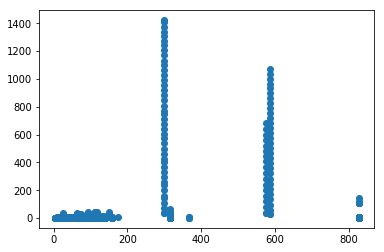

In [30]:
plt.scatter(res_df[NUM_TOTAL_REACTIONS], res_df[NUM_ERROR_REACTIONS])

(array([583.,  54.,  19.,  44.,  35.,  13.,   1.,   0.,  12.,  22.,   4.,
         13.,   0.,  28.,   0.,   0.,  38.,   0.,   9.,  10.,   0.,   0.,
          3.,  33.,   0.,   0.,   0.,   0.,   0.,  13.,   0.,   1.,   6.,
          4.,   3.,   0.,   6.,   9.,   0.,   0.,  13.,   0.,   0.,   0.,
          0.,   5.,   0.,  18.,   0.,   0.,   0.,  37.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   5.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          5.]),
 array([ 0.  ,  0.86,  1.72,  2.58,  3.44,  4.3 ,  5.16,  6.02,  6.88,
         7.74,  8.6 ,  9.46, 10.32, 11.18, 12.04, 12.9 , 13.76, 14.62,
        15.48, 16.34, 17.2 , 18.06, 18.92, 19.78, 20.64, 21.5 , 22.36,
        23.22, 24.08, 24.94, 25.8 , 26.66, 27.52, 28.38, 29.24, 30.1 ,
        30.96, 31.82, 32.68, 33.54

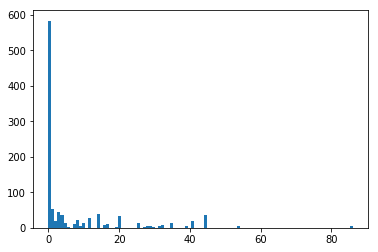

In [39]:
plt.hist(res_df[NUM_TOTAL_REACTIONS] - res_df[NUM_NONBDRY_REACTIONS], bins=100)

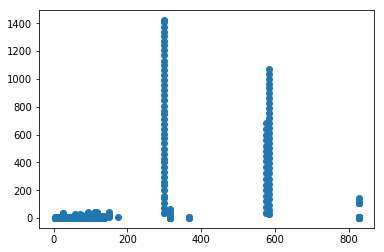

In [31]:
plt.scatter(res_df[NUM_NONBDRY_REACTIONS], res_df[NUM_ERROR_REACTIONS])

In [53]:
type1_res_df = res_df[res_df[ERROR_TYPE] == TYPE_I]
type2_res_df = res_df[res_df[ERROR_TYPE] == TYPE_II]
type3_res_df = res_df[res_df[ERROR_TYPE] == TYPE_III]
canceling_res_df = res_df[res_df[ERROR_TYPE] == CANCELING]
echelon_res_df = res_df[res_df[ERROR_TYPE] == ECHELON]

In [44]:
type1_res_df.head()

,error_type,model_id,num_error_reactions,num_nonbdry_reactions,num_total_reactions
0,type1,BIOMD0000000189,1,13,14
1,type1,BIOMD0000000189,1,13,14
2,type1,BIOMD0000000189,1,13,14
3,type1,BIOMD0000000189,3,13,14
6,type1,BIOMD0000000413,3,5,9


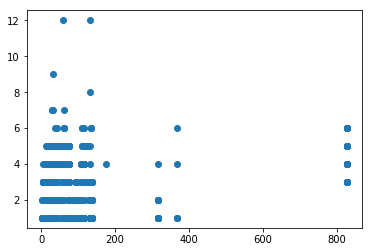

In [48]:
plt.scatter(type1_res_df[NUM_NONBDRY_REACTIONS], type1_res_df[NUM_ERROR_REACTIONS])

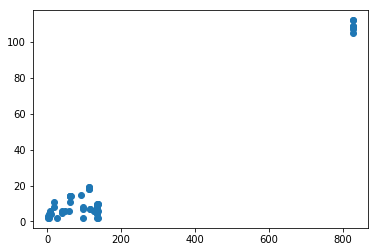

In [49]:
plt.scatter(type2_res_df[NUM_NONBDRY_REACTIONS], type2_res_df[NUM_ERROR_REACTIONS])

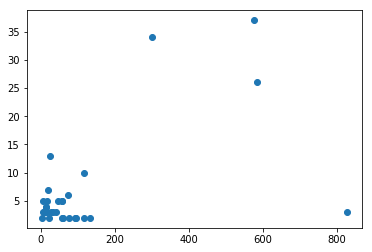

In [51]:
plt.scatter(type3_res_df[NUM_NONBDRY_REACTIONS], type3_res_df[NUM_ERROR_REACTIONS])

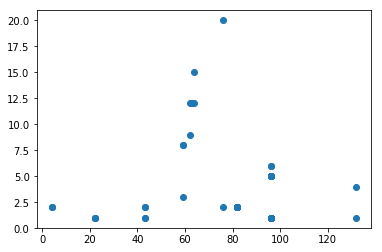

In [54]:
plt.scatter(canceling_res_df[NUM_NONBDRY_REACTIONS], canceling_res_df[NUM_ERROR_REACTIONS])

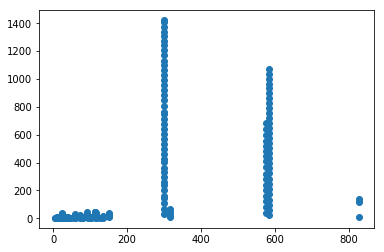

In [55]:
plt.scatter(echelon_res_df[NUM_NONBDRY_REACTIONS], echelon_res_df[NUM_ERROR_REACTIONS])

In [56]:
res_df[res_df[NUM_ERROR_REACTIONS] > 1000]

,error_type,model_id,num_error_reactions,num_nonbdry_reactions,num_total_reactions
162,echelon,BIOMD0000000014,1027,300,300
163,echelon,BIOMD0000000014,1063,300,300
164,echelon,BIOMD0000000014,1101,300,300
165,echelon,BIOMD0000000014,1132,300,300
166,echelon,BIOMD0000000014,1169,300,300
167,echelon,BIOMD0000000014,1207,300,300
168,echelon,BIOMD0000000014,1243,300,300
169,echelon,BIOMD0000000014,1274,300,300
170,echelon,BIOMD0000000014,1307,300,300
171,echelon,BIOMD0000000014,1341,300,300


In [61]:
res_df[res_df[NUM_ERROR_REACTIONS] > res_df[NUM_NONBDRY_REACTIONS]]

,error_type,model_id,num_error_reactions,num_nonbdry_reactions,num_total_reactions
142,echelon,BIOMD0000000014,331,300,300
143,echelon,BIOMD0000000014,364,300,300
144,echelon,BIOMD0000000014,403,300,300
145,echelon,BIOMD0000000014,424,300,300
146,echelon,BIOMD0000000014,464,300,300
147,echelon,BIOMD0000000014,499,300,300
148,echelon,BIOMD0000000014,536,300,300
149,echelon,BIOMD0000000014,572,300,300
150,echelon,BIOMD0000000014,604,300,300
151,echelon,BIOMD0000000014,642,300,300


In [12]:
count = 0
res_list
for file in files[:20]:
  count += 1
  simple = SimpleSBML()
  simple.initialize(os.path.join(data_dir, file))
  m = GAMES_PP(simple)
  s = StoichiometryMatrix(simple)
  num_total_reactions = len(simple.reactions)
  num_nonbdry_reactions = s.stoichiometry_matrix.shape[1]
  #print("num reactions: ", num_total_reactions)
  if simple.reactions:
    result = m.analyze(error_details=False)
    if result:
      dic = {}
      dic[MODEL_ID] = file[:-8]
      dic[NUM_TOTAL_REACTIONS] = num_total_reactions
      dic[NUM_NONBDRY_REACTIONS] = num_nonbdry_reactions
      gr = GAMESReport(m)
      errortype_dic = {TYPE_I: gr.reportTypeOneError,
                       TYPE_II: gr.reportTypeTwoError,
                       TYPE_III: gr.reportTypeThreeError,
                       CANCELING: gr.reportCancelingError,
                       ECHELON: gr.reportEchelonError
                        }
      summary = m.error_summary
      for errors_type in m.error_summary:
        for category in errortype_dic.keys():
          if errors_type.type == category:
            func = errortype_dic[category]            
            _, error_num = func(errors_type.errors)
            for num in error_num:
              res_dic = copy.deepcopy(dic)
              res_dic[ERROR_TYPE] = category
              res_dic[NUM_ERROR_REACTIONS] = num
              res_list.append(res_dic)
print("finished analysis")

finished analysis


In [13]:
#res_list

In [14]:
res_df = pd.DataFrame(res_list)
res_df

,error_type,model_id,num_error_reactions,num_nonbdry_reactions,num_total_reactions
0,type1,BIOMD0000000189,1,13,14
1,type1,BIOMD0000000189,1,13,14
2,type1,BIOMD0000000189,1,13,14
3,type1,BIOMD0000000189,3,13,14
4,type3,BIOMD0000000189,3,13,14
5,echelon,BIOMD0000000189,3,13,14
6,type1,BIOMD0000000413,3,5,9
7,type1,BIOMD0000000519,2,4,7
8,type1,BIOMD0000000519,2,4,7


In [ ]:
ERROR_TYPE = "error_type"
TYPE_I = "type1"
TYPE_II = "type2"
TYPE_III = "type3"
CANCELING = "canceling"
ECHELON = "echelon"